In [5]:
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [42]:
from datasets import Myloader
from networks_pyg.init import init_model
from utils.utils import get_congestion_start_end

In [7]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import argparse
import logging
from datetime import datetime, timedelta, date
import torch
import torch.nn.functional as F
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch_geometric.utils.convert import from_networkx

In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
# Data Loading
data_root_path = '/media/usr/HDD/Data/NAVER'
partition_list = os.listdir(data_root_path)
partition_list = [p for p in partition_list if p[0]=='2']
partition_list = np.sort(partition_list)

data_path = '/media/usr/HDD/Working/Naver_Data/data_parsing'

sids_all = []
eventID_all = []

for partition in partition_list:
    try: 
        eventID_list = [filename.split('.')[0] for filename in os.listdir(os.path.join(data_path, 'networks', partition)) if filename[0] != '.']
        eventID_list = np.unique(eventID_list)
        eventID_all.append(eventID_list)

        for eventID in eventID_list:
            with open(os.path.join(data_path, 'networks', partition, '{}.pickle'.format(eventID)), 'rb') as f:
                accident_info = pickle.load(f)
            G = nx.read_gpickle(os.path.join(data_path, 'networks', partition, '{}.gpickle'.format(eventID)))

            sids_all.append(accident_info[1])
            sids_all.append(accident_info[2])
    except:
        continue

eventID_all = [x for y in eventID_all for x in y]
eventID_all = np.unique(eventID_all)
        
sids_all = [x for y in sids_all for x in y]
sids_all = np.unique(sids_all)

print('# of all Events, # of sids = ', len(eventID_all), len(sids_all))

data_extraction_path = '/media/usr/HDD/Data/NAVER_df'
filtered_ID = [eventID for eventID in eventID_all if eventID in os.listdir(data_extraction_path)]

## load accident_all
accident_all = pd.read_csv('datasets/data/accident_all.csv', index_col=0)
print("# of filtered Events = ", len(accident_all))


# Profile Extraction Functions
def profile_extraction2(speed_all):
    # Day of Week => monday : 0, sunday : 6
    speed_all['weekday'] = [s.weekday() for s in speed_all.index]
    speed_all['timestamp'] = [s.time() for s in speed_all.index]
    
    profile_mean = speed_all.groupby(['weekday', 'timestamp']).mean()
    profile_std = speed_all.groupby(['weekday', 'timestamp']).std()
    
    speed_all = speed_all.drop(['weekday', 'timestamp'], axis=1)
    
    return speed_all, profile_mean, profile_std

# of all Events, # of sids =  4203 15629
# of filtered Events =  849


In [10]:
accident_all['accident_sid'].value_counts()

1210005301    20
1030001902    19
1220005401    15
1210003000    13
1130052300    12
              ..
2210066900     1
1120013402     1
1100005401     1
1070010402     1
1040020100     1
Name: accident_sid, Length: 482, dtype: int64

In [11]:
    target_sid = 1210005301 ## 1030001902    ## 1210005301
    accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == target_sid]
    eventID = accident_case.eventId.iloc[0]
    normalize = 'standard'

    eventID = str(eventID)

    # accident info : 0 : description / 1 : sid / 2 : sid 
    # what sids?
    with open(os.path.join(data_path, 'speeds', eventID, '{}.pickle'.format(eventID)), 'rb') as f:
        accident_info = pickle.load(f)
    G = nx.read_gpickle(os.path.join(data_path, 'speeds', eventID, '{}.gpickle'.format(eventID)))

    sid_list = accident_info[1] + accident_info[2]

    accident_sid = accident_info[0]['sids'][0]
    accident_created = accident_info[0]['created']

    # feature extraction
    with open(os.path.join(data_extraction_path, eventID), 'rb') as f:
        test = pickle.load(f)
    speed_inflow = test['speed_inflow']
    speed_outflow = test['speed_outflow']

    speed_all = pd.concat([speed_inflow, speed_outflow], axis=1)
    speed_all = speed_all.dropna(axis=1, how='all')
    
    tmp = speed_all[accident_sid].iloc[:, 0].values
    speed_all = speed_all.drop([accident_sid], axis=1)
    speed_all[accident_sid] = tmp

    ## selected nodes
    sid_list = list(set(list(speed_inflow.columns) + list(speed_outflow.columns) + [accident_sid]))
    H = nx.subgraph(G, sid_list)

    ## speed_all 5min rolling & normalize
    speed_all = speed_all.resample(rule='5T').mean()
    if normalize == 'standard':
        scaler = StandardScaler() 
        arr_scaled = scaler.fit_transform(speed_all) 
        df_all_norm = pd.DataFrame(arr_scaled, columns=speed_all.columns,index=speed_all.index)
    elif normalize == 'minmax':
        scaler = MinMaxScaler() 
        arr_scaled = scaler.fit_transform(speed_all) 
        df_all_norm = pd.DataFrame(arr_scaled, columns=speed_all.columns,index=speed_all.index)
    elif normalize == 'profile':
        ## profile extraction
        # profile_all = profile_extraction(df_all_norm)
        speed_all, profile_mean, profile_std = profile_extraction2(speed_all)

        ## profile normalization
        date_index = np.arange(datetime(2020, 9, 2), datetime(2021, 3, 1), timedelta(days=1)).astype(datetime)
        df_all_norm = speed_all.copy()

        for date in date_index:
            date_index = np.arange(date, date+timedelta(days=1), timedelta(minutes=5)).astype(datetime)
            tmp = speed_all.loc[date_index]
            weekday = date.weekday()
            mean_tmp = profile_mean[288*weekday:288*(weekday+1)]
            std_tmp = profile_std[288*weekday:288*(weekday+1)]

            normalized = (tmp.values - mean_tmp) / std_tmp
            df_all_norm.loc[date_index] = normalized.values

#         df_all_norm = df_all_norm.rolling(3).mean()

    # define anomaly label
    labels = []
    accident_case['created'] = pd.to_datetime(accident_case['created'])
    for ix, row in accident_case.iterrows():
        accident_created = row['created']
        min = accident_created.minute % 5
        sec = accident_created.second
        accident_pt = accident_created - timedelta(minutes=min, seconds=sec)
        labels.append(list(map(int, (df_all_norm.index >= accident_pt+timedelta(minutes=-60)) & (df_all_norm.index < accident_pt+timedelta(minutes=60)))))
    labels = list(map(int, (np.sum(labels, axis=0) > 0)))
    label_df = pd.DataFrame(labels, index=df_all_norm.index, columns=['label'])

/tmp/ipykernel_4041680/2781759659.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accident_case['created'] = pd.to_datetime(accident_case['created'])


In [ ]:
from datasets.Myloader import profile_loader
train_loader, val_loader, test_loader = profile_loader(df_all_norm, label_df, H)
len(train_loader), len(val_loader), len(test_loader)

## Congestion Label 수정

In [260]:
plot=True

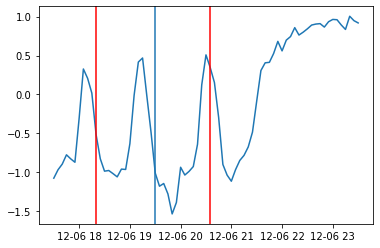

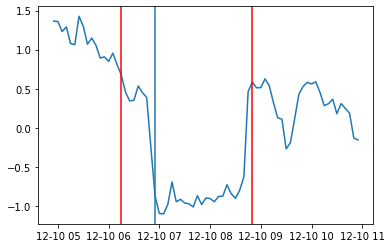

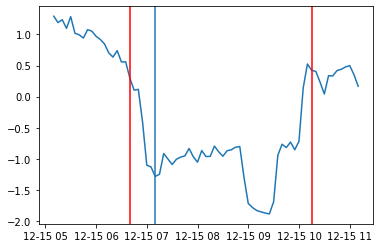

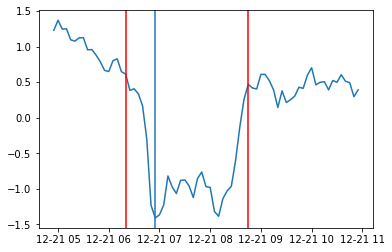

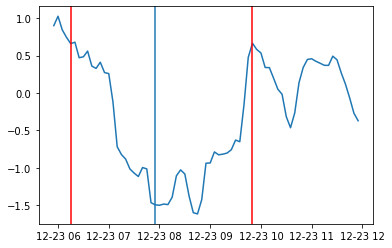

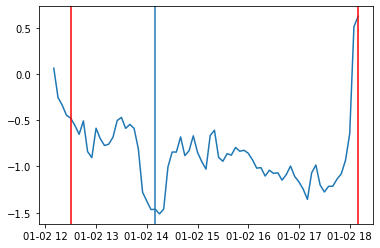

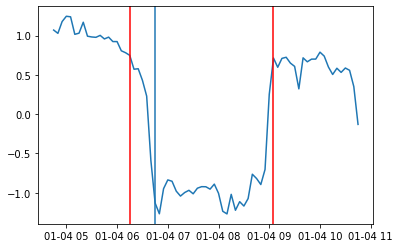

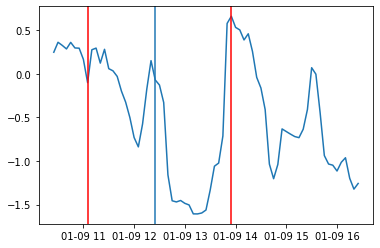

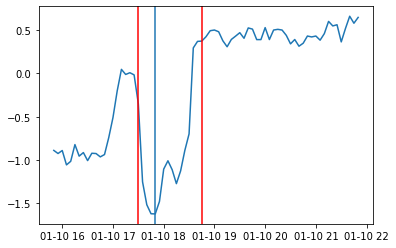

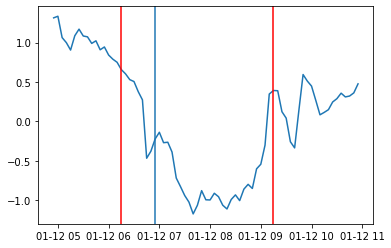

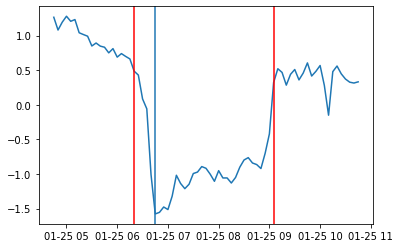

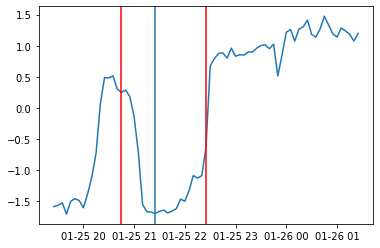

In [261]:
label_df = pd.DataFrame(0, index=df_all_norm.index, columns=['label'])
cnt = 0

## Incident Data Plot
for ix, row in accident_case.iterrows():
    t = row['created']
    if (t.month != 1) and (t.month != 12):
        continue
    
    eventID = str(row['eventId'])
    with open(os.path.join(data_path, 'speeds', eventID, '{}.pickle'.format(eventID)), 'rb') as f:
        accident_info = pickle.load(f)
        
    t = accident_info[0]['created'].to_pydatetime()
    t = datetime.fromtimestamp(round(t.timestamp( ) / 300 ) *300)
    accident_idx = np.where(df_all_norm.index == t)[0][0]
    df_pre = df_all_norm[t - timedelta(minutes=120):t]
    if df_pre.mean()[accident_sid] > 0:
        df_start_condition = (df_pre.mean() > df_all_norm)[accident_sid]
    else:
        df_start_condition = (df_pre.quantile(0.8) > df_all_norm)[accident_sid]
    df_start_condition = df_start_condition.astype(int).diff()==1
    
    congestion_start_list = np.where(df_start_condition==True)[0]
    congestion_start_list = np.unique([idx for idx in congestion_start_list if (accident_idx - 12*2 <= idx) & (idx <= accident_idx)])
    congestion_start_time = df_all_norm.index[congestion_start_list[0]].to_pydatetime()

#     df_end_condition = (df_pre.mean() < df_all_norm)[accident_sid]
#     congestion_end_list = np.where(df_end_condition==True)[0]
#     congestion_end_list = np.unique([idx for idx in congestion_end_list if (accident_idx - 12*2 <= idx) & (idx <= accident_idx)])
    
    df_avg_pre_new = df_all_norm[congestion_start_time - timedelta(minutes=120):accident_dt]
    df_end_condition = (df_avg_pre_new.mean() < df_all_norm.rolling(3).mean())[accident_sid]
    df_end_condition = df_end_condition.astype(int).diff()==1
    congestion_end_list = np.where(df_end_condition==True)[0]
    congestion_end_list = [idx for idx in congestion_end_list if (accident_idx <= idx) & (idx <= accident_idx + 12*4) & (accident_idx <= idx)]
    if len(congestion_end_list) == 0:
        congestion_end_list = [accident_idx+12]
    congestion_end_time = df_all_norm.index[congestion_end_list[0]].to_pydatetime()

#     congestion_start_time, congestion_end_time, _ = get_congestion_start_end(df_avg, accident_info, std_min=30, start_period=12*2, end_period=12*24, gap=120/5)
    if plot==True:
        plt.figure()
        plt.plot(df_all_norm[t+timedelta(minutes=-120) :t+timedelta(minutes=240)][accident_sid])
        plt.axvline(congestion_start_time, color='red')
        plt.axvline(congestion_end_time, color='red')
        plt.axvline(t)
        
    cnt += 1
    ## Label generation
    label_df[congestion_start_time:congestion_end_time] = 1

    

label    425
dtype: int64

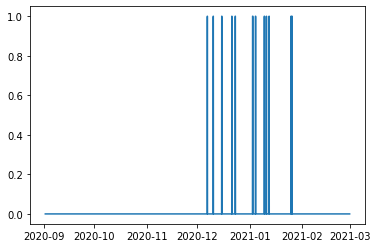

In [258]:
plt.plot(label_df)
label_df.sum()

## Normal Data

In [13]:
path_inflow = test['path_inflow']
path_outflow = test['path_outflow']

In [14]:
df_agg_inflow, df_agg_outflow = [], []
for hop in [0, 1, 2, 3]:
    inflow = np.unique([p[hop] for p in path_inflow])
    outflow = np.unique([p[hop] for p in path_outflow])
    df_agg_inflow.append(df_all_norm[inflow].mean(axis=1))
    df_agg_outflow.append(df_all_norm[outflow].mean(axis=1))
df_agg_inflow = pd.concat(df_agg_inflow, axis=1)
df_agg_outflow = pd.concat(df_agg_outflow, axis=1)

In [15]:
df_agg_inflow = df_agg_inflow.rolling(3).mean()

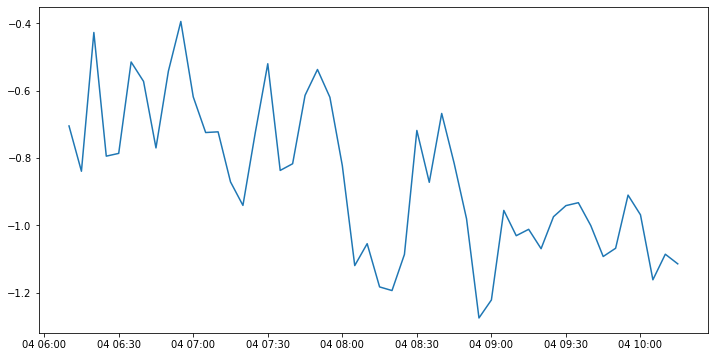

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(df_all_norm[650:700][accident_sid])

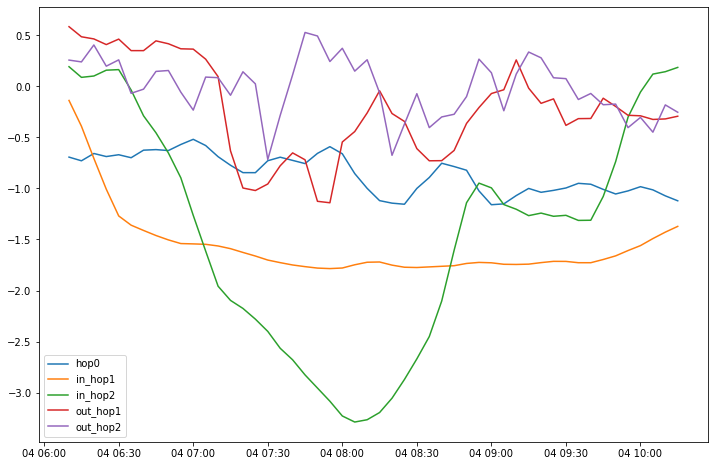

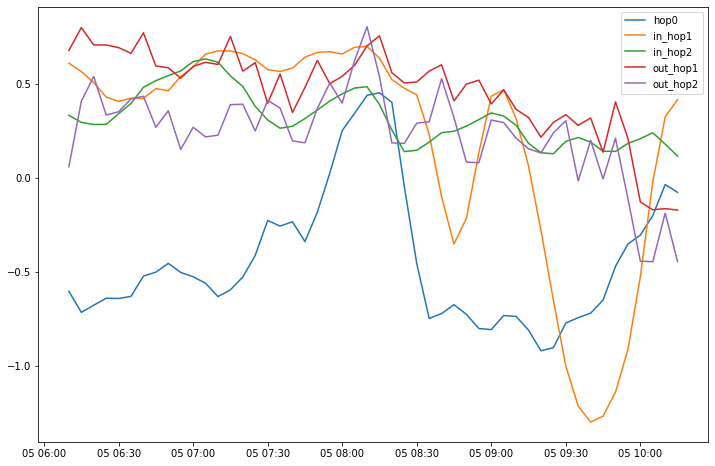

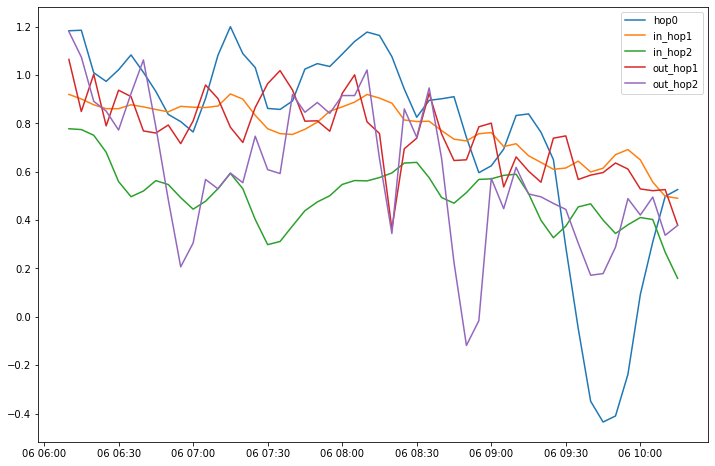

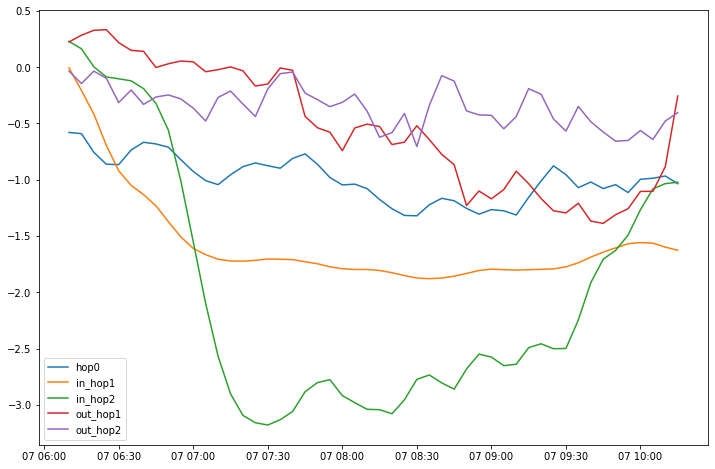

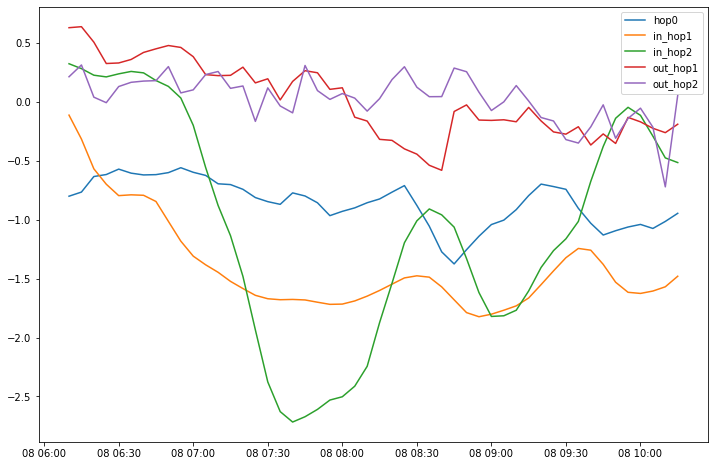

In [19]:
for i in range(5):
    t0 = 650 + 288*i
    t1 = 700 + 288*i
    plt.figure(figsize=(12, 8))
    plt.plot(df_agg_inflow.iloc[t0:t1][0], label='hop0')
    plt.plot(df_agg_inflow[t0:t1][1], label='in_hop1')
    plt.plot(df_agg_inflow[t0:t1][2], label='in_hop2')
    plt.plot(df_agg_outflow[t0:t1][1], label='out_hop1')
    plt.plot(df_agg_outflow[t0:t1][2], label='out_hop2')
    plt.legend()
    plt.show()

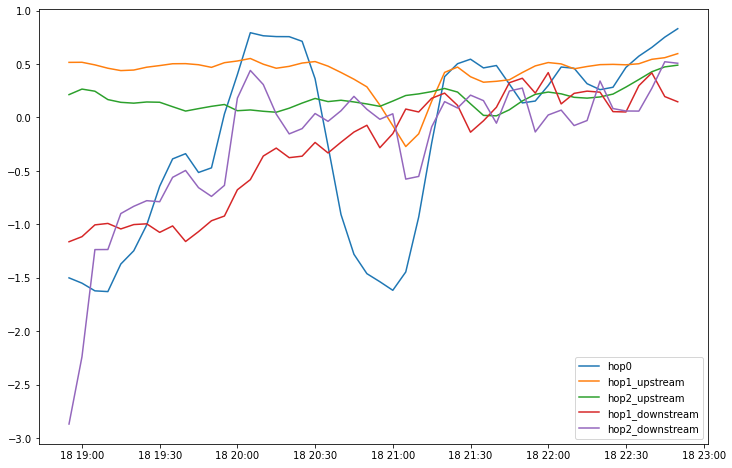

In [20]:
for ix, row in accident_case.iloc[-1:].iterrows():
    t = row['created']
    t0 = (df_all_norm.index > t+timedelta(minutes=-120))
    t1 = (df_all_norm.index <= t+timedelta(minutes=120))
    plt.figure(figsize=(12, 8))
    plt.plot(df_agg_inflow[t0&t1][0], label='hop0')
    plt.plot(df_agg_inflow[t0&t1][1], label='hop1_upstream')
    plt.plot(df_agg_inflow[t0&t1][2], label='hop2_upstream')
    plt.plot(df_agg_outflow[t0&t1][1], label='hop1_downstream')
    plt.plot(df_agg_outflow[t0&t1][2], label='hop2_downstream')
    plt.legend()

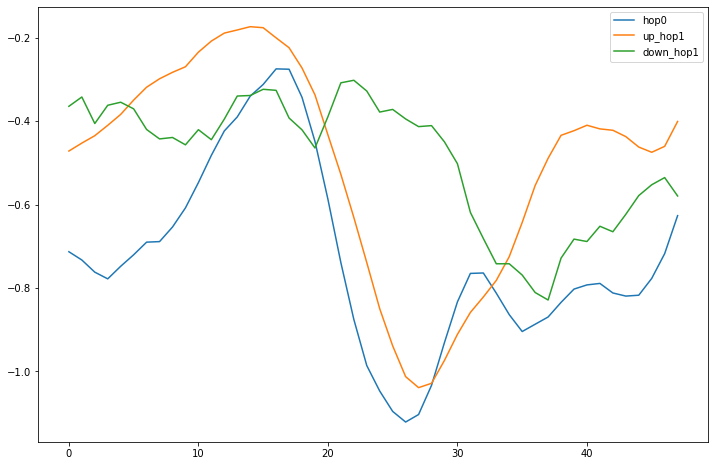

In [21]:
acc_agg, up_agg, down_agg = [], [], []
for ix, row in accident_case.iterrows():
    t = row['created']
    t0 = (df_all_norm.index > t+timedelta(minutes=-120))
    t1 = (df_all_norm.index <= t+timedelta(minutes=120))
    acc_agg.append(df_agg_inflow[t0&t1][0].values)
    up_agg.append(df_agg_inflow[t0&t1][1].values)
    down_agg.append(df_agg_outflow[t0&t1][1].values)

# acc_aggregation = np.mean(acc_aggregation,axis=0)
plt.figure(figsize=(12, 8))
# plt.plot(np.median(acc_agg,axis=0), label='hop0')
# plt.plot(np.median(up_agg,axis=0), label='up')
# plt.plot(np.median(down_agg,axis=0), label='down')
plt.plot(np.mean(acc_agg,axis=0), label='hop0')
plt.plot(np.mean(up_agg,axis=0), label='up_hop1')
plt.plot(np.mean(down_agg,axis=0), label='down_hop1')
# for i in range(len(acc_agg)):
#     plt.plot(acc_agg[i])
#     if i == 5:
#         break
# plt.plot(df_agg_inflow[t0&t1][1], label='hop1_upstream')
# plt.plot(df_agg_inflow[t0&t1][2], label='hop2_upstream')
# plt.plot(df_agg_outflow[t0&t1][1], label='hop1_downstream')
# plt.plot(df_agg_outflow[t0&t1][2], label='hop2_downstream')
plt.legend()

## NaN values 

In [13]:
train_df = df_all_norm[df_all_norm.index < datetime(2020, 12, 1)]
val_df = df_all_norm[(df_all_norm.index >= datetime(2020, 12, 1)) & (df_all_norm.index < datetime(2021, 1, 1))]
test_df = df_all_norm[(df_all_norm.index >= datetime(2021, 1, 1)) & (df_all_norm.index < datetime(2021, 2, 1))]

In [14]:
train_df.shape, test_df.shape

((25920, 21), (8928, 21))

In [15]:
train_df.isna().sum()

sid
1030001800     14
1030002400     16
1030002701     14
1030016506     17
1030040600     95
1030041300     14
1030045400    226
1030065700     14
1050000301     14
1050060000     14
1020000902     14
1030000500     14
1030000700     14
1030001100     14
1030001300     14
1030008004     14
1030026600     91
1030028600     14
1030029200     14
1030029600     14
1030001902     14
dtype: int64

In [16]:
test_df.isna().sum()

sid
1030001800     12
1030002400     12
1030002701     12
1030016506     19
1030040600     87
1030041300     12
1030045400    158
1030065700     12
1050000301     12
1050060000     12
1020000902     12
1030000500     12
1030000700     12
1030001100     12
1030001300     12
1030008004     12
1030026600    129
1030028600     12
1030029200     12
1030029600     12
1030001902     12
dtype: int64

In [19]:
train_df.bfill(limit=36).ffill(limit=36).fillna(0, limit=288).isna().sum()

sid
1030001800    0
1030002400    0
1030002701    0
1030016506    0
1030040600    0
1030041300    0
1030045400    0
1030065700    0
1050000301    0
1050060000    0
1020000902    0
1030000500    0
1030000700    0
1030001100    0
1030001300    0
1030008004    0
1030026600    0
1030028600    0
1030029200    0
1030029600    0
1030001902    0
dtype: int64

In [23]:
train_df.bfill(limit=36).ffill(limit=36).isna().sum()

sid
1030001800    0
1030002400    0
1030002701    0
1030016506    0
1030040600    0
1030041300    0
1030045400    4
1030065700    0
1050000301    0
1050060000    0
1020000902    0
1030000500    0
1030000700    0
1030001100    0
1030001300    0
1030008004    0
1030026600    0
1030028600    0
1030029200    0
1030029600    0
1030001902    0
dtype: int64

In [24]:
test_df.bfill(limit=36).ffill(limit=36).isna().sum()

sid
1030001800    0
1030002400    0
1030002701    0
1030016506    0
1030040600    0
1030041300    0
1030045400    0
1030065700    0
1050000301    0
1050060000    0
1020000902    0
1030000500    0
1030000700    0
1030001100    0
1030001300    0
1030008004    0
1030026600    0
1030028600    0
1030029200    0
1030029600    0
1030001902    0
dtype: int64